In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import cancer_data
import many

import config

from scipy.stats import fisher_exact

config.config_visuals()

In [3]:
def as_si(x: float, decimals: int) -> str:
    """
    Convert a number to scientific notation

    Parameters
    ----------
    x : float
        number to convert
    decimals: float
        number of decimal places

    Returns
    -------
    x_si : string
        x formatted in scientific notation
    """

    s = "{x:0.{ndp:d}e}".format(x=x, ndp=decimals)
    m, e = s.split("e")
    x_si = r"{m:s} × $10^{{{e:d}}}$".format(m=m, e=int(e))

    return x_si

def binary_contingency(a, b, ax=None, heatmap_kwargs={}):
    """
    Plot agreement between two binary variables, along with
    the odds ratio and Fisher's exact test p-value.

    Parameters
    ----------
    a : Boolean series
        boolean series of first variable
    y : Boolean series
        boolean series of second variable
    ax : MatPlotLib axis
        axis to plot in (will create new one if not provided)
    heatmap_kwargs : dictionary
        additional arguments to pass to seaborn.heatmap()

    Returns
    -------
    ax : MatPlotLib axis
        axis with plot data
    """

    # convert, align, and cast
    a, b = pd.Series(a), pd.Series(b)
    a, b = a.dropna(), b.dropna()
    a, b = a.astype(bool), b.astype(bool)

    a, b = a.align(b, join="inner")

    # store names before array conversion
    a_name = a.name
    b_name = b.name

    a, b = np.array(a), np.array(b)

    # compute contingency counts
    xx = np.sum(a & b)
    xy = np.sum(a & ~b)
    yx = np.sum(~a & b)
    yy = np.sum(~a & ~b)

    # create 2x2 contingency table
    contingency = pd.DataFrame(
        [[xx, xy], [yx, yy]],
        columns=["True", "False"],
        index=["True", "False"],
    )

    odds_ratio, p_val = fisher_exact([[xx, xy], [yx, yy]])

    print("Odds ratio:", odds_ratio)
    print("P-value:", p_val)

    # if axis not provided, make figure
    if ax is None:

        plt.figure(figsize=(4, 4))
        ax = plt.subplot(111)

    # plot the contingency table as heatmap
    g = sns.heatmap(
        contingency,
        fmt="d",
        annot=True,
        cbar=False,
        linewidths=2,
        ax=ax,
        **heatmap_kwargs,
    )

    plt.ylabel(a_name)
    plt.xlabel(b_name)

    g.xaxis.tick_top()
    g.xaxis.set_label_position("top")

    return ax, odds_ratio, p_val


In [4]:
merged_ccle_info = pd.read_csv(
    "../data/supplementary/S1_merged-ccle-info.txt", sep="\t", index_col=0
)
merged_tcga_info = pd.read_csv(
    "../data/supplementary/S2_merged-tcga-info.txt", sep="\t", index_col=0
)

Odds ratio: 0.0900187149095446
P-value: 5.4527915862515895e-18
Odds ratio: 0.09799571603427172
P-value: 1.316472137428829e-12
Odds ratio: 0.010833295241577914
P-value: 4.175870465483947e-24
Odds ratio: 0.059069962295768746
P-value: 2.0048414569809113e-09
Odds ratio: 0.11208539839878003
P-value: 7.243567524266505e-10
Odds ratio: 0.0
P-value: 1.79648563230827e-11


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 39 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'D', 'E', 'I', 'L', 'M', 'O', 'P', 'R', 'S', 'T', 'U', 'W', 'comma', 'd', 'eight', 'equal', 'f', 'five', 'four', 'k', 'm', 'multiply', 'nine', 'nonmarkingreturn', 'one', 'period', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 15, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 32, 36, 38,

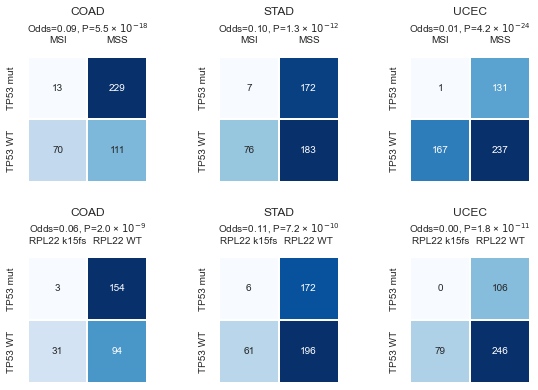

In [20]:
def plot_subset_contingency(subset_type, second_col, second_col_labels, title, ax):

    subset = merged_tcga_info[merged_tcga_info["Sample_type"] == "Primary Tumor"].copy()
    subset = subset[subset["Primary_disease"] == subset_type]
    subset["TP53_del"] = subset["TP53_copy_number_thresholded"].dropna() <= -1
    
    _, odds_ratio, pval = binary_contingency(
#         subset["TP53_mutation_cbioportal"].dropna() != "no alteration",
        subset["TP53_del"].dropna(),
        subset[second_col].dropna(),
        ax=ax,
        heatmap_kwargs={"cmap":"Blues"},
    )

    ax.set_title(title)

    ax.set_xticklabels(second_col_labels)
    ax.set_yticklabels(["TP53 mut", "TP53 WT"])

    ax.set_xlabel(f"Odds={odds_ratio:.2f}, P={as_si(pval,1)}")
    ax.set_ylabel(None)
    
    ax.tick_params(
        axis="x",
        which="both",
        bottom=False,
        top=False,
    )
    
    ax.tick_params(
        axis="y",
        which="both",
        left=False,
        right=False,
    )


fig, axes = plt.subplots(2, 3, figsize=(9, 6))

plot_subset_contingency(
    "colon adenocarcinoma", "MSI", ["MSI", "MSS"], "COAD", axes[0][0]
)
plot_subset_contingency(
    "stomach adenocarcinoma", "MSI", ["MSI", "MSS"], "STAD", axes[0][1]
)
plot_subset_contingency(
    "uterine corpus endometrioid carcinoma", "MSI", ["MSI", "MSS"], "UCEC", axes[0][2]
)

plot_subset_contingency(
    "colon adenocarcinoma",
    "RPL22_k15fs_mutation",
    ["RPL22 k15fs", "RPL22 WT"],
    "COAD",
    axes[1][0],
)
plot_subset_contingency(
    "stomach adenocarcinoma",
    "RPL22_k15fs_mutation",
    ["RPL22 k15fs", "RPL22 WT"],
    "STAD",
    axes[1][1],
)
plot_subset_contingency(
    "uterine corpus endometrioid carcinoma",
    "RPL22_k15fs_mutation",
    ["RPL22 k15fs", "RPL22 WT"],
    "UCEC",
    axes[1][2],
)

plt.subplots_adjust(wspace=0.6, hspace=0.6)

plt.savefig("../plots/fig-s5_TP53-RPL22k15-MSI_contingency.pdf", bbox_inches="tight")

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 40 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'D', 'E', 'I', 'L', 'M', 'O', 'P', 'R', 'S', 'T', 'U', 'a', 'd', 'e', 'eight', 'equal', 'f', 'five', 'four', 'i', 'k', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'parenleft', 'parenright', 's', 'space', 't', 'three', 'two', 'u', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 19, 20, 21, 22, 23, 24, 27, 32, 36, 38, 39, 40, 44, 47

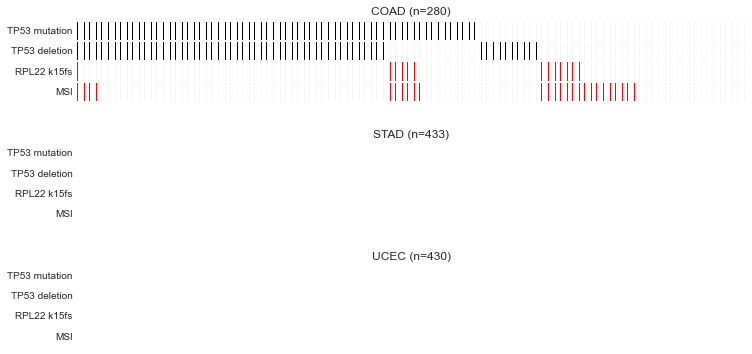

In [17]:
def plot_subset(subset_type=None, ax=None, heatmap_kwargs={}):

    if ax is None:

        plt.figure(figsize=(12, 2))
        ax = plt.subplot(111)

    if subset_type is None:

        subset = merged_tcga_info[
            merged_tcga_info["Sample_type"] == "Primary Tumor"
        ].copy()

    else:

        subset = merged_tcga_info[
            (merged_tcga_info["Abbreviated_disease"] == subset_type)
            & (merged_tcga_info["Sample_type"] == "Primary Tumor")
        ].copy()

    # define TP53 altered
    subset["TP53_mut"] = subset["TP53_mutation_cbioportal"].dropna() != "no alteration"
    subset["TP53_del"] = subset["TP53_copy_number_thresholded"].dropna() <= -1
#     subset["RPL22_del"] = subset["RPL22_copy_number_thresholded"].dropna() <= -1
    
    # drop missing annotations
    subset = subset[["TP53_del", "TP53_mut", "RPL22_k15fs_mutation", "MSI"]].dropna()

    # sort before plotting
    subset = subset.sort_values(
        ["TP53_mut", "TP53_del", "RPL22_k15fs_mutation", "MSI"], ascending=False
    )

    subset["RPL22_k15fs_mutation"] *= 2
    subset["MSI"] *= 3

    sns.heatmap(
        subset[["TP53_mut", "TP53_del", "RPL22_k15fs_mutation", "MSI"]].astype(int).T,
        cbar=False,
        xticklabels=False,
        cmap=sns.color_palette(["whitesmoke", "black", "red", "red"]),
        ax=ax,
        **heatmap_kwargs,
    )

    # set tick labels
    ax.set_yticklabels(["TP53 mutation", "TP53 deletion", "RPL22 k15fs", "MSI"])
    ax.tick_params(axis="both", which="both", length=0)

    if subset_type:

        ax.set_title(f"{subset_type} (n={len(subset)})")


fig, axes = plt.subplots(3, 1, figsize=(12, 6))

heatmap_kwargs = {"linewidth": 0.25}

plot_subset("COAD", ax=axes[0], heatmap_kwargs=heatmap_kwargs)
plot_subset("STAD", ax=axes[1], heatmap_kwargs=heatmap_kwargs)
plot_subset(
    "UCEC", ax=axes[2], heatmap_kwargs=heatmap_kwargs
)

plt.subplots_adjust(hspace=0.5)

plt.savefig("../plots/fig-s5_TP53-RPL22k15.pdf", bbox_inches="tight")